# Tackling Imbalanced Dataset with Stroke Dataset

## What's the point?
The purpose of this exercise is to dive deeper into the techniques and strategies handling of Imbalanced Datasets as a machine learning classification problem. 

## Imbalanced Dataset
An imbalanced dataset is when the distribution of the target classes of either a binary or multi-class dataset are not uniformed. These types of dataset usually show up in problems like disease detection, machine failure detection or fraud detection where the class that we are trying to detect (stroke/heart attack occurences, fraud events and machine failure events) belong to only a minority of the class distribution. This is because events such as fraud, failures or even stroke are rather uncommon. 

## So, what's the big deal about it?
Even though the events that we are trying to detect are uncommon, the costs of those events happening and catching us unprepared are usually very, very expensive. For example, the cost of fixing a failed machine is usually more expensive than turning off the machine for predictive maintenance. The cost of having a stroke or heart attack is definitely more expensive than to have an early detection and prevention of those diseases. 

## Dataset Used
We are using the Stroke dataset provided in Kaggle (URL: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset#). A disclaimer to put forth upfront is that the original source of this dataset was not divulged by the Kaggler, hence the validity or the authenticity of the dataset cannot be determined. That being said, the nature of the dataset is still presented to us as an "Imbalanced Classification" problem.

## What is covered in this Notebook?
This Notebook starts off **Exploratory Data Analysis (EDA)** of the data where we look at the basic statistical distribution of the data, determining the data quality and getting a basic understanding of how each feature correlates to our target variable (Stroke or No Stroke).

The dataset is split into `train` and `test` sets. We ensure that the distribution of the imbalanced classes is preserved for both `train` and `test` sets using `StratifiedShuffleSplit`.

We then proceed to the **Data Preparation** stage where we look into different techniques of imputation, feature scaling and categorical enconding. We prepare a pipeline for these data preparation steps using Scikit-Learn's `pipeline`. This `pipeline` is then used as the input to the models that we will evaluate later.

In the **Modeling** stage, we look into different models, starting from Logistic Regression, Random Forest, Support Vector Machine (SVM) and Bagging Classifiers to determine the model as our baseline performance. Main determinant metric used as Recall  scores.

During this time, we also look into how we can **handle the imbalanced classes** by employing techniques such as Random Oversampling, Random Undersampling and Synthetic Minority Oversampling Technique (SMOTe). We then evaluate the model performance for these techniques used. Apart from this, we also explore using different variations of models such as Balanced Random Forest, Balanced Bagging Classifier and Penalized SVM.

Once this experiment was completed, we selected "Balanced Random Forest" model as our **basecase model** for finetuning.

In the **finetuning** stage, we employ `RandomSearchCV` followed by `GridSearchCV` to determine the best combinations of hyperparameters for the model

Once the model is finetuned, we perform **threshold sensitivities** to determine which threshold would provide the best model metric performance.

We **test our final model against the test set** that was split at the very beginning.

The supplementary portion of this also includes the **explainability of the model**'s predictions through Random Forest's `feature importance`, where we determine which feature has the highest impact on the prediction of the model.


## Metric Used 
As we do not have a reference for this dataset, we are using **Recall** score as our main primary metric as we would prefer to have higher number of stroke prediction. Since the cost of not detecting stroke when there is is higher, we would like to be able to detect more stroke patients than missing them out.

## Techniques employed to tackle the imbalanced distribution
    . Sampling technqiues (Random Oversampling, Random Undersampling SMOTe)
    . Moving threshold
    . Customized models 

In [1]:
#%pip install -U imbalanced-learn seaborn

In [108]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_curve, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, accuracy_score, classification_report, fbeta_score, make_scorer

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint as pp
import joblib

### Load Data & First Look

In [20]:
# set a random state value to be used throughout our evaluation
RANDOM_STATE = 158

# setting up the path for the dataset
DATA_PATH = Path("./dataset")
os.listdir(DATA_PATH)

['healthcare-dataset-stroke-data.csv']

In [21]:
data_original = pd.read_csv(DATA_PATH / 'healthcare-dataset-stroke-data.csv')

In [22]:
df = data_original.copy()

In [23]:
df.sample(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1306,1678,Female,54.0,1,0,Yes,Private,Rural,98.74,NaN,never smoked,0
1258,22295,Female,25.0,0,0,No,Private,Urban,82.77,36.3,Unknown,0
503,51112,Male,29.0,0,0,Yes,Self-employed,Urban,118.70,33.2,Unknown,0
1973,65229,Female,17.0,0,0,No,Private,Rural,55.41,25.4,Unknown,0
2764,20292,Female,24.0,0,0,Yes,Private,Urban,85.55,63.3,never smoked,0


In [24]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


> - Only `bmi` has null values:
>       - #TODO : fill_na
> - `age` starts from 0.08 years old

In [25]:
df[df["work_type"] == "children"].describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,687.000000,687.000000,687.0,687.000000,687.000000,671.000000,687.000000
mean,35769.432314,6.841339,0.0,0.001456,94.400277,20.038003,0.002911
std,21005.291797,4.533364,0.0,0.038152,26.658955,4.540639,0.053916
min,77.000000,0.080000,0.0,0.000000,55.340000,10.300000,0.000000
25%,16583.000000,2.000000,0.0,0.000000,76.255000,17.150000,0.000000
50%,35106.000000,6.000000,0.0,0.000000,90.220000,18.900000,0.000000
75%,53933.500000,11.000000,0.0,0.000000,108.710000,21.600000,0.000000
max,72940.000000,16.000000,0.0,1.000000,219.810000,41.700000,1.000000


> - "children" category in `work_type` has maximum age of 16 years old.

In [26]:
df[df["age"] <= 16]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1
249,30669,Male,3.00,0,0,No,children,Rural,95.12,18.0,Unknown,0
251,16523,Female,8.00,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,46136,Male,14.00,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5089,56714,Female,0.72,0,0,No,children,Rural,62.13,16.8,Unknown,0
5094,28048,Male,13.00,0,0,No,children,Urban,82.38,24.3,Unknown,0
5095,68598,Male,1.08,0,0,No,children,Rural,79.15,17.4,Unknown,0
5098,579,Male,9.00,0,0,No,children,Urban,71.88,17.5,Unknown,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [28]:
for col in df.columns:
    if df[col].dtype != "float64":
        print(col, ":", df[col].unique())

id : [ 9046 51676 31112 ... 19723 37544 44679]
gender : ['Male' 'Female' 'Other']
hypertension : [0 1]
heart_disease : [1 0]
ever_married : ['Yes' 'No']
work_type : ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type : ['Urban' 'Rural']
smoking_status : ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke : [1 0]


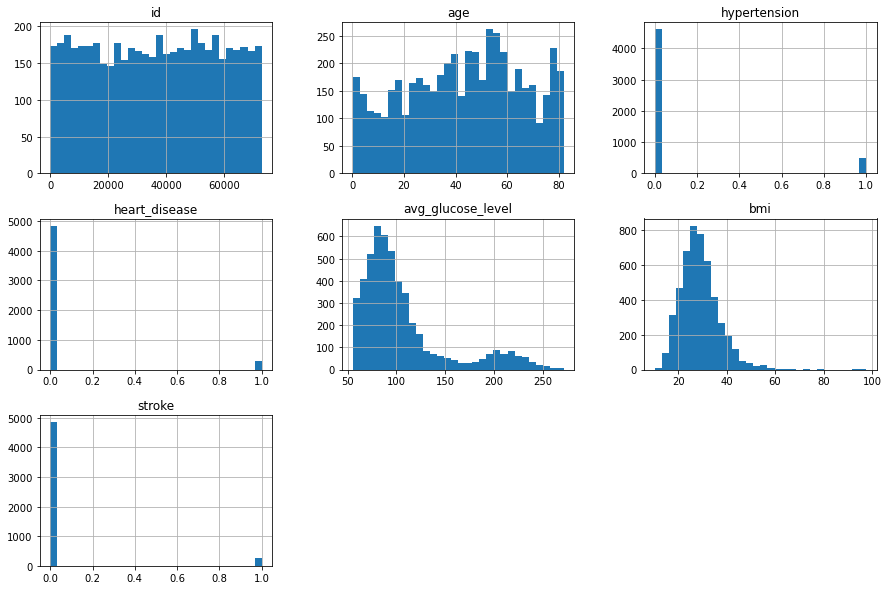

In [29]:
df.hist(bins = 30, figsize=(15,10))
plt.show()

In [30]:
print("***** Distribution of `Stroke` variable *****")
print(df["stroke"].value_counts() / len(df))
print(Counter(df["stroke"]))

***** Distribution of `Stroke` variable *****
0    0.951272
1    0.048728
Name: stroke, dtype: float64
Counter({0: 4861, 1: 249})


> - Our binary dependent variable `stroke` is highly imbalanced (~ 1:20 ratio). We have more examples of patients without stroke than those with stroke.
>     * #TODO: Perform re-sampling techniques
> - We also have some of the variables (`avg_glucose_level` and `bmi`) which are skewed to the left
>     * #TODO: perform transformations

### Splitting data for Test Set

#### Stratified Split by the distribution of `stroke`

Since we have a severely imbalanced dataset for our target (`stroke`), we should split our training and test sets according to its distribution.

In [31]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=RANDOM_STATE)
for train_idx, test_idx in splitter.split(df, df["stroke"]):
    train_set = df.loc[train_idx]
    test_set = df.loc[test_idx]

In [32]:
print("***** Train set distribution *****")
print(train_set["stroke"].value_counts() / len(train_set))
print()
print("***** Test set distribution *****")
print(test_set["stroke"].value_counts() / len(test_set))

***** Train set distribution *****
0    0.951321
1    0.048679
Name: stroke, dtype: float64

***** Test set distribution *****
0    0.951076
1    0.048924
Name: stroke, dtype: float64


### Exploratory Data Analysis (EDA)

In [33]:
df = train_set.copy()

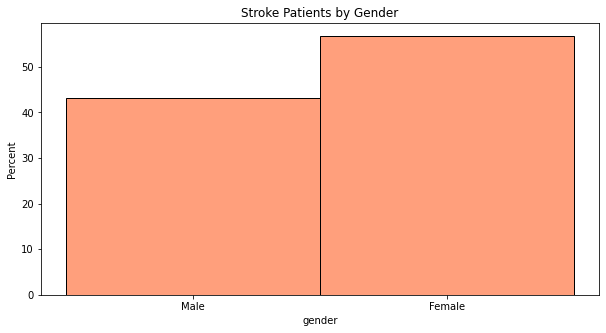

In [34]:
plt.figure(figsize=(10,5))
# percentage = df[df["stroke"]==1]["gender"].value_counts() / len(df[df["stroke"]==1]["gender"]) * 100

plot = sns.histplot(data = df[df["stroke"]==1], x="gender", color="coral", stat="percent")

# plot.text("Male", 60, str(round(percentage["Male"],1)) + " %")
# plot.text("Female", 60, str(round(percentage["Female"],1)) + " %")
    
plt.title("Stroke Patients by Gender")
plt.show()

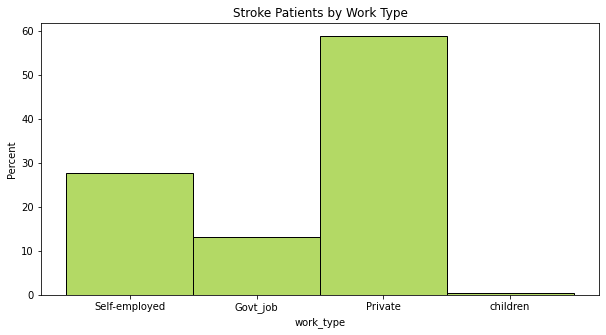

In [35]:
plt.figure(figsize=(10,5))

plot = sns.histplot(data = df[df["stroke"]==1], x="work_type", color="yellowgreen", stat="percent")

plt.title("Stroke Patients by Work Type")
plt.show()

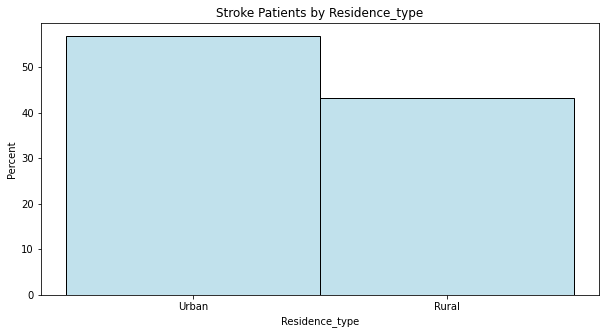

In [36]:
plt.figure(figsize=(10,5))

plot = sns.histplot(data = df[df["stroke"]==1], x="Residence_type", color="lightblue", stat="percent")

plt.title("Stroke Patients by Residence_type")
plt.show()

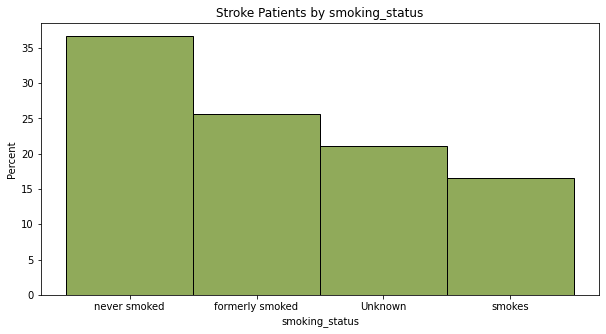

In [37]:
plt.figure(figsize=(10,5))

plot = sns.histplot(data = df[df["stroke"]==1], x="smoking_status", color="olivedrab", stat="percent")

plt.title("Stroke Patients by smoking_status")
plt.show()

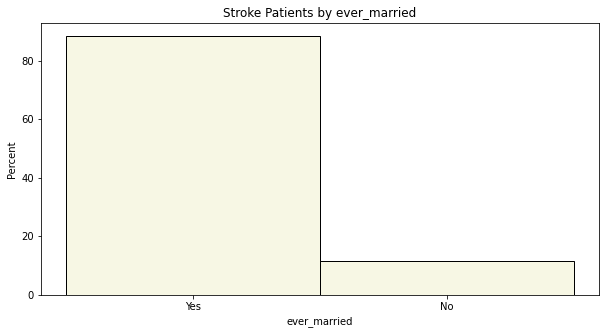

In [38]:
plt.figure(figsize=(10,5))

plot = sns.histplot(data = df[df["stroke"]==1], x="ever_married", color="beige", stat="percent")

plt.title("Stroke Patients by ever_married")
plt.show()

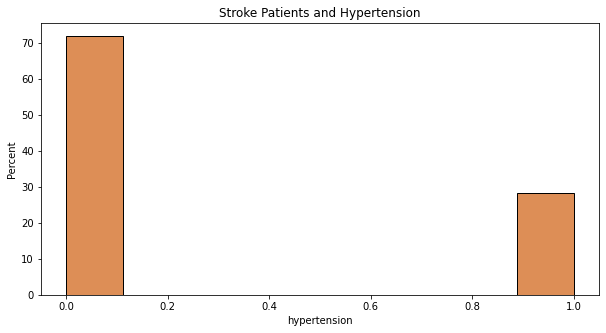

In [39]:
plt.figure(figsize=(10,5))

plot = sns.histplot(data = df[df["stroke"]==1], x="hypertension", color="chocolate", stat="percent")

plt.title("Stroke Patients and Hypertension")
plt.show()

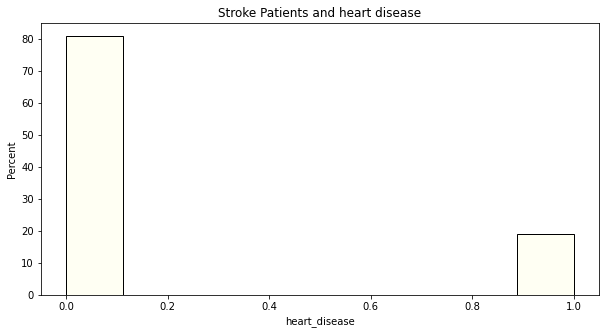

In [40]:
plt.figure(figsize=(10,5))

plot = sns.histplot(data = df[df["stroke"]==1], x="heart_disease", color="ivory", stat="percent")

plt.title("Stroke Patients and heart disease")
plt.show()

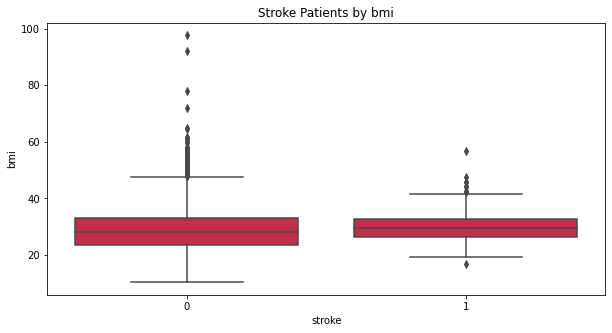

In [41]:
plt.figure(figsize=(10,5))

plot = sns.boxplot(data = df, x="stroke", y="bmi", color="crimson")

plt.title("Stroke Patients by bmi")
plt.show()

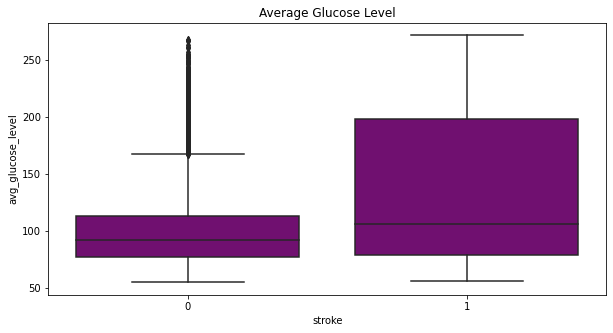

In [126]:
plt.figure(figsize=(10,5))

plot = sns.boxplot(data = df, x="stroke", y='avg_glucose_level', color="purple")

plt.title("Average Glucose Level")
plt.show()

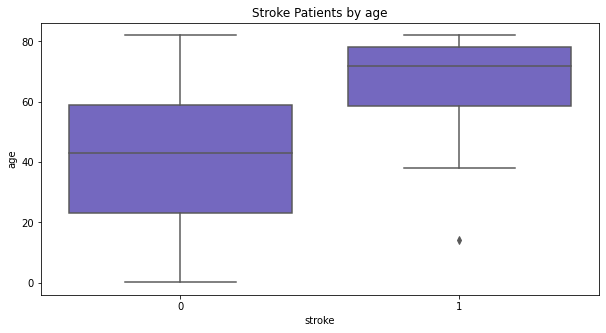

In [43]:
plt.figure(figsize=(10,5))

plot = sns.boxplot(data = df, x="stroke", y="age", color="slateblue")

plt.title("Stroke Patients by age")
plt.show()

> It seems like `age` has a strong correlation with `stroke` -- almost all of the stroke cases seem to happen around 60 years old and above. 

### Data Preparation

#### Prepare `X_train` & `y_train` and `X_test` & `y_test`

In [44]:
X_train = train_set.drop(columns=["stroke"]).copy()
y_train = train_set["stroke"].copy()

X_test = test_set.drop(columns=["stroke"]).copy()
y_test = test_set["stroke"].copy()

#### Null Values in `bmi`

Recall that `bmi` has some null values

In [45]:
X_train.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  162
smoking_status         0
dtype: int64

In [46]:
num_columns = ["age", "avg_glucose_level", "bmi"]
df_nums = X_train[num_columns]

In [47]:
imputer = SimpleImputer(strategy="median")
df_nums_imputed = imputer.fit_transform(df_nums)

In [48]:
np.isnan(df_nums_imputed).sum()

0

#### Categorical Variables

In [49]:
cat_columns = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]
df_cats = X_train[cat_columns]

In [50]:
cat_encoder = OneHotEncoder()
df_cats_1hot = cat_encoder.fit_transform(df_cats)
df_cats_1hot

<4088x19 sparse matrix of type '<class 'numpy.float64'>'
	with 28616 stored elements in Compressed Sparse Row format>

In [51]:
cat_encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array([0, 1]),
 array([0, 1]),
 array(['No', 'Yes'], dtype=object),
 array(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
       dtype=object),
 array(['Rural', 'Urban'], dtype=object),
 array(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
       dtype=object)]

#### Feature Scaling
We will use Standard Scaler (_standardization_) to scale our variables

In [52]:
scaler = StandardScaler()

df_nums_scaled = scaler.fit_transform(df_nums)

#### Transformation Pipeline

In [56]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

df_nums_transformed = num_pipeline.fit_transform(df_nums)

In [57]:
full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_columns),
    ("categorical", OneHotEncoder(), cat_columns)
])

##### Transform `X_train` and `X_test`

**⚠ Midway finding!**

In [58]:
for col in cat_columns:
    print(f"---------- {col} ---------")
    print(f"X_train: {X_train[col].unique()}")
    print(f"X_test: {X_test[col].unique()}")
    print()

---------- gender ---------
X_train: ['Female' 'Male']
X_test: ['Female' 'Male' 'Other']

---------- hypertension ---------
X_train: [0 1]
X_test: [0 1]

---------- heart_disease ---------
X_train: [0 1]
X_test: [0 1]

---------- ever_married ---------
X_train: ['No' 'Yes']
X_test: ['No' 'Yes']

---------- work_type ---------
X_train: ['Private' 'children' 'Self-employed' 'Govt_job' 'Never_worked']
X_test: ['children' 'Self-employed' 'Private' 'Never_worked' 'Govt_job']

---------- Residence_type ---------
X_train: ['Urban' 'Rural']
X_test: ['Urban' 'Rural']

---------- smoking_status ---------
X_train: ['never smoked' 'smokes' 'Unknown' 'formerly smoked']
X_test: ['Unknown' 'formerly smoked' 'smokes' 'never smoked']



In [59]:
X_test[X_test["gender"] == "Other"]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked


> Mid-way finding: I found out at the very end of the test set evaluation that there is one patient entry with `gender` as "Other" (belonging to the Majority class "No Stroke"), and it is showing up in our test set (instead of training). This caused some issues with the models that we have trained so far especially with One-Hot-Encoding, where we have considered the unique values in the train_set only -- which we shouldn't have.  Technically we should create OHE pipeline based on the values that shows up in the whole dataset (train+test).

> However, as I would not want to re-train all of my models again, and to make my life easier, I decided to do a little bit of cheating. I will impute this entry's gender as the "mode" of the majority class "No Stroke". It should not affect the model performance whatsoever, as it is i) only one entry ii) belongs to the majority class

Using `data_original`, we will get the mode of `gender` for the majority class (No Stroke)

In [60]:
gender_mode = data_original.loc[data_original["stroke"]==0, "gender"].mode()
print(f"Gender mode for majority class (No Stroke) is {gender_mode.values[0]}")

Gender mode for majority class (No Stroke) is Female


In [61]:
gender_mode.values[0]

'Female'

In [62]:
X_test.loc[X_test["gender"] == "Other", "gender"] = gender_mode.values[0]

Lets check our `X_test` again

In [63]:
X_test["gender"].unique()

array(['Female', 'Male'], dtype=object)

> All good! Now we can transform it again

In [64]:
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.fit_transform(X_test)

In [65]:
X_train_transformed.shape[1] == X_test_transformed.shape[1]

True

> Good! Now we have the same dimensions of the features for both `X_train` and `X_test`

### Modeling Time!

In [66]:
def train_fit_model(model, X_train, y_train, **model_kwargs):
    '''
    Function that takes in standard sklearn modle along with its sklearn arguments
    '''
    clf = model(**model_kwargs)
    clf.fit(X_train, y_train)
    return clf

In [68]:
def plot_roc_curve(fpr, tpr):
    # plot fpr and tpr
    plt.plot(fpr, tpr, linewidth=2)
    # plot diagnoal line
    plt.plot([0,1], [0,1], "b--")
    plt.title("ROC Curve")
    plt.ylabel("True Positive Rate (Recall)")
    plt.xlabel("False Positive Rate")

def plot_confusion(y_train, y_train_pred):
    disp=ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred))
    disp.plot()
    plt.title("Confusion Matrix")

def plot_precision_recall_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.title("Precision / Recall vs Threshold")
    plt.ylabel("Precision / Recall")
    plt.xlabel("Threshold")
    plt.legend()

In [69]:
def evaluate_model_metrics(y_train, y_train_pred):
    '''
    Calculates, stores and prints model metrics
    
    - Recall or True Positive Rate (expressed as percentage), which is also called Sensitivity 
    is the probability that a test result will be positive when the disease is present. Hence,
        Recall = TP / (TP+FN)

    - Specificity or False Positive Rate (expresssed as percentage), 
    is probability that a test result will be negative when the disease is not present. Hence,
        Specificity = TN / (FP+TN)

    - Precision is basically how many of the positive predictions were actually correctly predicted as positive. 
        Precision = TP / (TP+FP)
    
    
    (Ref: https://www.publichealth.columbia.edu/research/population-health-methods/evaluating-risk-prediction-roc-curves)
    
    '''
    
    # custom calculation for specificity
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
    specificity = round(tn / (tn+fp), 2)
    
    precision = round(precision_score(y_train, y_train_pred), 2)
    recall = round(recall_score(y_train, y_train_pred), 2)
    f1 = round(f1_score(y_train, y_train_pred), 2)
    f2 = round(fbeta_score(y_train, y_train_pred, beta=2), 2)
    roc_score = round(roc_auc_score(y_train, y_train_pred), 2)
    accuracy = round(accuracy_score(y_train, y_train_pred), 2)
    bal_accuracy = round(balanced_accuracy_score(y_train, y_train_pred), 2)
    
    print("Precision Score:", precision)
    print("Recall Score:", recall)
    print("Specificity Score:", specificity)
    print("F1 Score:", f1)
    print("F2 Score:", f2)
    print("AUC Score:", roc_score)
    print("Accuracy Score:", accuracy)
    print("Balanced Accuracy:", bal_accuracy)
    
    return {"Precision": precision, 
            "Recall": recall, 
            "Specificity": specificity,
            "F1": f1, 
            "F2": f2,
            "ROC": roc_score, 
            "Accuracy": accuracy, 
            "Balanced_Accuracy": bal_accuracy}

def evaluate_model(model, X_train, y_train, cv=3, ensemble=False, threshold:float=None):
    '''
    - Cross Validate model with training set. 
    - Plots Confusion Matrix
    - Plots AUC Curve
    - Prints Precision, Recall, F1_Score and AUC Score
    '''
    def threshold_prediction(model, threshold, X):
        prediction_proba = model.predict_proba(X)
        
        return (prediction_proba[:,1] >= threshold)

    # plot confusion matrix
    if threshold:
        y_train_pred = threshold_prediction(model, threshold, X_train).astype("int")
        plot_confusion(y_train, y_train_pred)
        plt.show()
    else:
        y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
        plot_confusion(y_train, y_train_pred)
        plt.show()
        
        # plot precision_recall_treshold and roc curves
        if ensemble:
            # if using Random Forest
            y_probas = cross_val_predict(model, X_train, y_train, cv=cv,
                                         method="predict_proba")
            y_scores = y_probas[:, 1]
            
        else:
            y_scores = cross_val_predict(model, X_train, y_train, cv=cv, 
                                    method="decision_function")

        precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
        plot_precision_recall_threshold(precisions, recalls, thresholds)
        plt.show()

        fpr, tpr, thresholds = roc_curve(y_train, y_scores)
        plot_roc_curve(fpr, tpr)
        plt.show()

    return evaluate_model_metrics(y_train, y_train_pred)


In [70]:
# create an empty dictionary to store all our models
model_results = {}

In [72]:
# print results
def print_results(dictionary=model_results):
    return pd.DataFrame.from_dict(dictionary, "index")

##### Logistic Regression

In [73]:
logit_clf = train_fit_model(LogisticRegression, X_train_transformed, y_train, random_state=RANDOM_STATE)

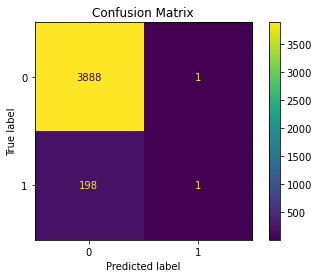

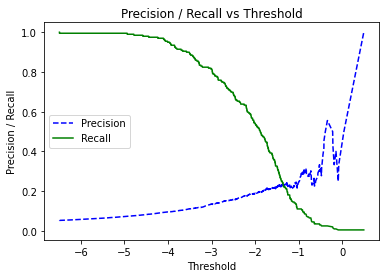

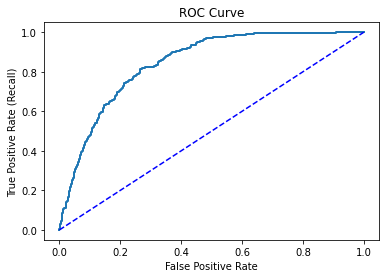

Precision Score: 0.5
Recall Score: 0.01
Specificity Score: 1.0
F1 Score: 0.01
F2 Score: 0.01
AUC Score: 0.5
Accuracy Score: 0.95
Balanced Accuracy: 0.5


In [74]:
model_results["logit_clf"] = evaluate_model(logit_clf, X_train_transformed, y_train)

**True Positive Rate (expressed as percentage), $TPR$ is another name for $Recall$, which is also called $Sensitivity$** is the probability that a test result will be positive when the disease is present. Hence,

$$ {TPR} = {Recall\ or\ Sensitivity} = \frac{TP}{TP+FN}$$
<br><br>

**False Positive Rate (expresssed as percentage), which is also called $Specificity$** is probability that a test result will be negative when the disease is not present. Hence,

$$ 
\begin{align}
{TNR} = {Specificity} = \frac{TN}{FP+TN} 
\end{align}
$$

**Precision is basically how many of the positive predictions were actually correctly predicted as positive**. Hence,

$$
\begin{align}
{Precision} = \frac{TP}{TP+FP}
\end{align}
$$



> - Even though the accuracy was 95%, but oh man, this is the recall was terrible!
     * Extremely low Recall score means that of all the supposed 199 Stroke patients that come in, we only managed to detect 1 one them as stroke patient
     * Specificity of ~ 1.0 shows that the model is able to make very good predictions about "No Stroke" (True Negatives).
          * Of the 3889 non-stroke patient in the database, it managed to detect 3888 of them.
> - Precision of 0.5 shows that out of the 2 positive predictions, 1 of them was correctly predicted as positive
> - We can see that the balanced accuracy (~0.5) is what gives us a better idea of the model performance.

> - It is very clear that the model is making a highly imbalanced predictions, favoring "No Stroke" classes over "Stroke" classes.
>    * This is due to the imbalance in the dependent variable classes (higher number of "No Stroke" instances than "Stroke")

Let's check out the only 2 True Positive predictions.

In [75]:
y_train_pred = cross_val_predict(logit_clf, X_train_transformed, y_train,cv=3)
X_train[y_train_pred == 1]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
187,67895,Female,82.0,1,1,Yes,Govt_job,Urban,215.94,27.9,formerly smoked
4164,40163,Female,82.0,1,0,Yes,Private,Urban,222.52,NaN,formerly smoked


#### Logistic Regression with SMOTE Resampling

Because of the imbalance in the classes (majority "No Stroke"), the vanilla `LogisticRegression` out of the box will be completely biased to the majority class. 

We can alleviate this by creating "Synthetic" minority dataset based on its distribution using `SMOTe`. 

`SMOTe`, which stands for Synthetic Minority Over-sampling Technique, will take a sample from the minority dataset, find its k-nearest neighbors and obtain a vector between the sample and one of the k neighbors and multiply that with a random number between 0 and 1.

One important thing to be careful about oversampling is data leakage, in which case, during training time, our model happens to be seeing data points that are similar to points that were supposedly kept away for the cross-validation stage. 

To avoid this, `imblearn` also provides its version of `Pipeline` that would allow us to only resample only within the each fold during the cross validation stage (as opposed to resampling the whole training data).  

In [76]:
steps = [("over", SMOTE(random_state=RANDOM_STATE)), 
         ("model", logit_clf)]
resampling_pipeline = Pipeline(steps=steps)

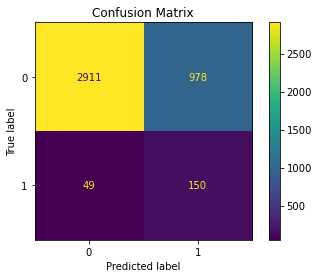

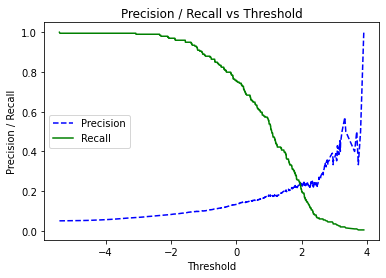

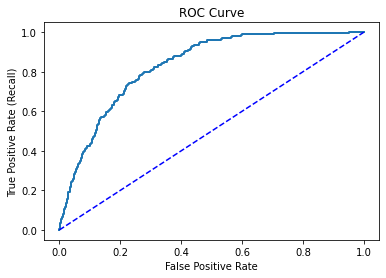

Precision Score: 0.13
Recall Score: 0.75
Specificity Score: 0.75
F1 Score: 0.23
F2 Score: 0.39
AUC Score: 0.75
Accuracy Score: 0.75
Balanced Accuracy: 0.75


In [77]:
model_results["logit_clf_smote"] = evaluate_model(resampling_pipeline, X_train_transformed, y_train)

In [78]:
print_results()

,Precision,Recall,Specificity,F1,F2,ROC,Accuracy,Balanced_Accuracy
logit_clf,0.50,0.01,1.00,0.01,0.01,0.50,0.95,0.50
logit_clf_smote,0.13,0.75,0.75,0.23,0.39,0.75,0.75,0.75


Major improvements in our model performance! We can see now that the model is making better "Stroke" predictions (True Positives) 

##### Random Forest

In [79]:
rf_clf = train_fit_model(RandomForestClassifier, 
                        X_train=X_train_transformed, 
                        y_train=y_train,
                        random_state=RANDOM_STATE)

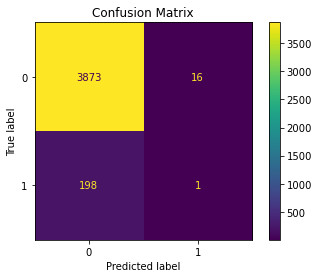

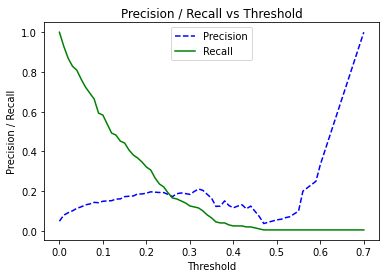

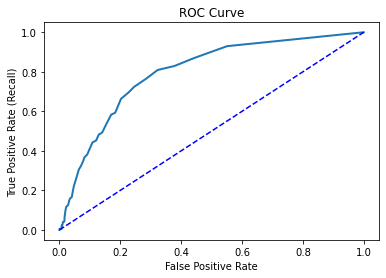

Precision Score: 0.06
Recall Score: 0.01
Specificity Score: 1.0
F1 Score: 0.01
F2 Score: 0.01
AUC Score: 0.5
Accuracy Score: 0.95
Balanced Accuracy: 0.5


In [80]:
model_results["rf_clf"] = evaluate_model(model = rf_clf, X_train=X_train_transformed, y_train=y_train, ensemble=True)

Similar to our `LogisticRegression`, `RandomForestClassifier` will also be biased towards the majority class.

##### Random Forest with Combined Resampling

In [81]:
steps = [("over", SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)), 
         ("under", RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)),
         ("model", rf_clf)]
resampling_pipeline = Pipeline(steps=steps)

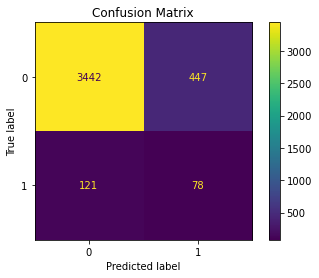

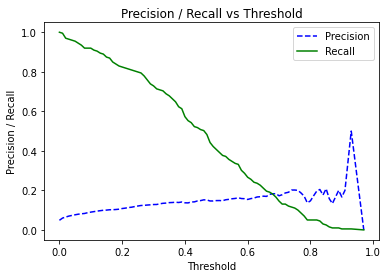

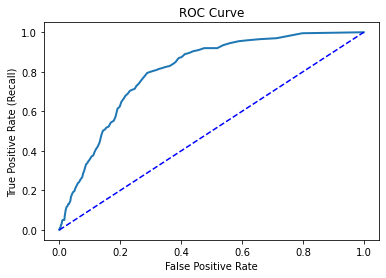

Precision Score: 0.15
Recall Score: 0.39
Specificity Score: 0.89
F1 Score: 0.22
F2 Score: 0.3
AUC Score: 0.64
Accuracy Score: 0.86
Balanced Accuracy: 0.64


In [82]:
model_results["rf_clf_smote"] = evaluate_model(resampling_pipeline, X_train=X_train_transformed, y_train=y_train, ensemble=True)

In [83]:
print_results()

,Precision,Recall,Specificity,F1,F2,ROC,Accuracy,Balanced_Accuracy
logit_clf,0.50,0.01,1.00,0.01,0.01,0.50,0.95,0.50
logit_clf_smote,0.13,0.75,0.75,0.23,0.39,0.75,0.75,0.75
rf_clf,0.06,0.01,1.00,0.01,0.01,0.50,0.95,0.50
rf_clf_smote,0.15,0.39,0.89,0.22,0.30,0.64,0.86,0.64


> Not any better than our Logistic Regression model with SMOTe `logit_clf_smote`.

##### Penalized Support Vector Machine (SVM)

Let's try it out Penalized Support Vector Machine (SVM) model. It will penalize on wrong predictions of the minority classes more.

In [84]:
psvm_clf = train_fit_model(SVC, 
                            X_train=X_train_transformed, 
                            y_train=y_train, 
                            random_state=RANDOM_STATE, 
                            kernel="linear", 
                            class_weight="balanced", 
                            probability=True)


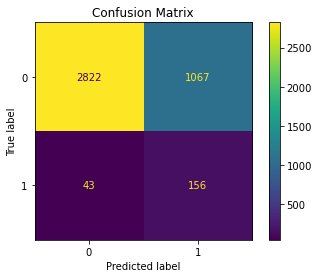

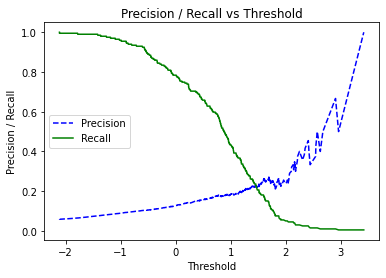

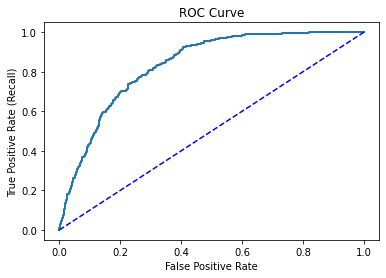

Precision Score: 0.13
Recall Score: 0.78
Specificity Score: 0.73
F1 Score: 0.22
F2 Score: 0.39
AUC Score: 0.75
Accuracy Score: 0.73
Balanced Accuracy: 0.75


In [85]:
model_results["psvm_clf"] = evaluate_model(model = psvm_clf, X_train=X_train_transformed, y_train=y_train)

In [88]:
print_results()

,Precision,Recall,Specificity,F1,F2,ROC,Accuracy,Balanced_Accuracy
logit_clf,0.50,0.01,1.00,0.01,0.01,0.50,0.95,0.50
logit_clf_smote,0.13,0.75,0.75,0.23,0.39,0.75,0.75,0.75
rf_clf,0.06,0.01,1.00,0.01,0.01,0.50,0.95,0.50
rf_clf_smote,0.15,0.39,0.89,0.22,0.30,0.64,0.86,0.64
psvm_clf,0.13,0.78,0.73,0.22,0.39,0.75,0.73,0.75


> - This seems like a better model than even the LogisticRegression with SMOTe model (`logit_clf_smote`)
>    * Out of the total of 196 Actual Positive (Stroke) instancess, it is now making 155 instances of correctly predicted Stroke cases (True Positives), translating that into higher Recall score. This is valuable because we would want to make sure that the patients that come in with stroke get detected early. 
>    * However, we can see that the Precision has dropped significantly. It is now predicting a lot more "False Positives" - ie more patients without strokes in reality may end up in overtreatment for strokes (not too good either!)
> - The Penalized SVC model gives more "attention" to the minority classes.

#### Balanced Random Forest

`BalancedRandomForestClassifier` provided by is pretty much the same standard `RandomForestClassifier` from scikit-learn, except that each tree of the balanced forest will be provided a balanced bootstrap sample (by randomly under-sampling each boostrap sample). This will help the model to not "look too much" at the majority class at each bootstrap.

In [90]:
bal_rf_clf = train_fit_model(BalancedRandomForestClassifier, 
                             X_train=X_train_transformed, 
                             y_train=y_train,
                             random_state=RANDOM_STATE,
                             n_estimators=100)

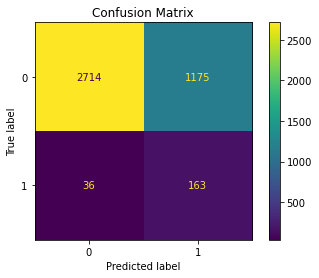

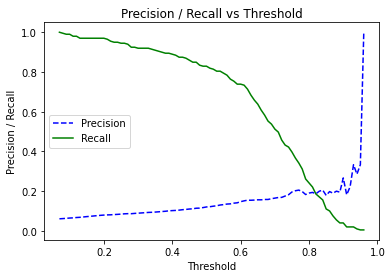

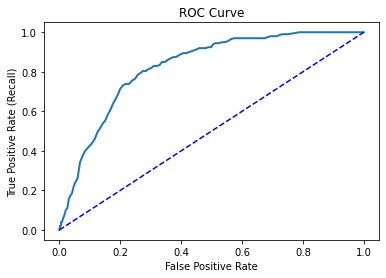

Precision Score: 0.12
Recall Score: 0.82
Specificity Score: 0.7
F1 Score: 0.21
F2 Score: 0.38
AUC Score: 0.76
Accuracy Score: 0.7
Balanced Accuracy: 0.76


In [91]:
model_results["bal_rf_clf"] = evaluate_model(bal_rf_clf, X_train=X_train_transformed, y_train=y_train, ensemble=True)

In [92]:
print_results()

,Precision,Recall,Specificity,F1,F2,ROC,Accuracy,Balanced_Accuracy
logit_clf,0.50,0.01,1.00,0.01,0.01,0.50,0.95,0.50
logit_clf_smote,0.13,0.75,0.75,0.23,0.39,0.75,0.75,0.75
rf_clf,0.06,0.01,1.00,0.01,0.01,0.50,0.95,0.50
rf_clf_smote,0.15,0.39,0.89,0.22,0.30,0.64,0.86,0.64
psvm_clf,0.13,0.78,0.73,0.22,0.39,0.75,0.73,0.75
bal_rf_clf,0.12,0.82,0.70,0.21,0.38,0.76,0.70,0.76


#### Balanced Random Forest (no One-Hot-Encoding)

Let's test out to see if One-Hot-Encoding does affect the performance of the results. For this we need to create a separate pipeline that would use `OrdinalEncoder()` on the features

In [93]:
full_pipeline_ordinalencoder = ColumnTransformer([
    ("numerical", num_pipeline, num_columns),
    ("categorical", OrdinalEncoder(), cat_columns)
])

In [94]:
X_train_OE_transformed = full_pipeline_ordinalencoder.fit_transform(X_train)
X_test_OE_transformed = full_pipeline_ordinalencoder.fit_transform(X_test)

In [95]:
print("X_train:", X_train_OE_transformed.shape)
print("X_test:", X_test_OE_transformed.shape)

X_train: (4088, 10)
X_test: (1022, 10)


In [96]:
bal_rf_OE_clf = train_fit_model(BalancedRandomForestClassifier, 
                             X_train=X_train_OE_transformed, 
                             y_train=y_train,
                             random_state=RANDOM_STATE,
                             n_estimators=100)

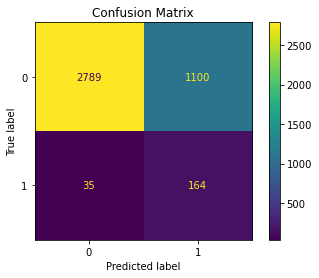

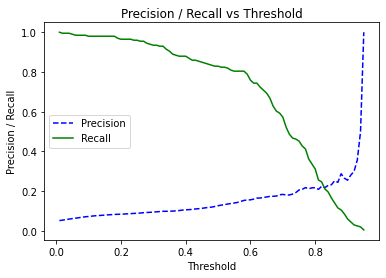

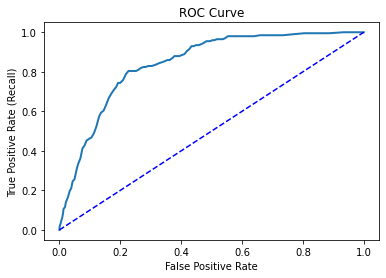

Precision Score: 0.13
Recall Score: 0.82
Specificity Score: 0.72
F1 Score: 0.22
F2 Score: 0.4
AUC Score: 0.77
Accuracy Score: 0.72
Balanced Accuracy: 0.77


In [97]:
model_results["bal_rf_OE_clf"] = evaluate_model(bal_rf_OE_clf, X_train=X_train_OE_transformed, y_train=y_train, ensemble=True)

In [98]:
print_results()

,Precision,Recall,Specificity,F1,F2,ROC,Accuracy,Balanced_Accuracy
logit_clf,0.50,0.01,1.00,0.01,0.01,0.50,0.95,0.50
logit_clf_smote,0.13,0.75,0.75,0.23,0.39,0.75,0.75,0.75
rf_clf,0.06,0.01,1.00,0.01,0.01,0.50,0.95,0.50
rf_clf_smote,0.15,0.39,0.89,0.22,0.30,0.64,0.86,0.64
psvm_clf,0.13,0.78,0.73,0.22,0.39,0.75,0.73,0.75
bal_rf_clf,0.12,0.82,0.70,0.21,0.38,0.76,0.70,0.76
bal_rf_OE_clf,0.13,0.82,0.72,0.22,0.40,0.77,0.72,0.77


> Not much difference; just a tad bit improvements in ROC. We'll just stick with the normal `pipeline`

#### Balanced Bagging Classifier

The standard `BaggingClassifier` build several estimators on different randomly selected subset of data. In `BalancedBaggingClassifier`, each bootstrap sample will be further resampled to achieve the `sampling_strategy` desired.

In [99]:
bal_bag_clf = train_fit_model(BalancedBaggingClassifier, 
                             X_train=X_train_transformed, 
                             y_train=y_train,
                             random_state=RANDOM_STATE,
                             n_estimators=100)

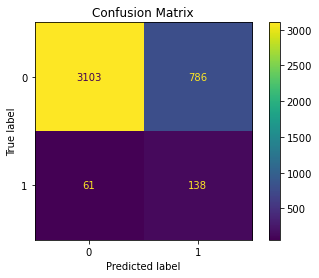

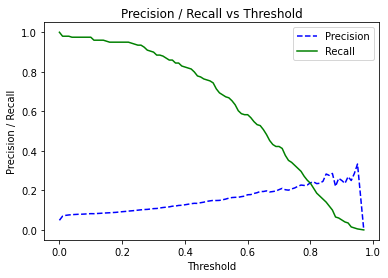

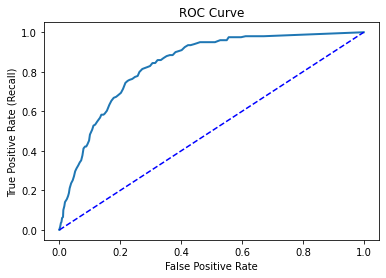

Precision Score: 0.15
Recall Score: 0.69
Specificity Score: 0.8
F1 Score: 0.25
F2 Score: 0.4
AUC Score: 0.75
Accuracy Score: 0.79
Balanced Accuracy: 0.75


In [100]:
model_results["bal_bag_clf"] = evaluate_model(bal_bag_clf, X_train=X_train_transformed, y_train=y_train, ensemble=True)

`BalancedBaggingClassifier` also allows us to choose the kind of sampling method that we want to perform:

 ======= Balanced Bag Classifier Sampler: RandUnderSamp ======= 


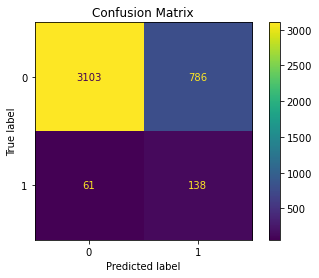

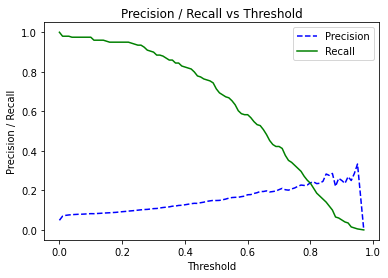

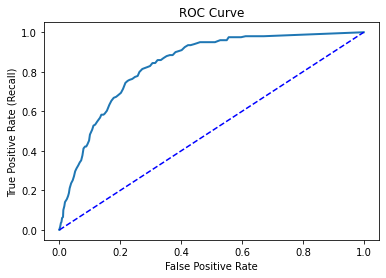

Precision Score: 0.15
Recall Score: 0.69
Specificity Score: 0.8
F1 Score: 0.25
F2 Score: 0.4
AUC Score: 0.75
Accuracy Score: 0.79
Balanced Accuracy: 0.75

 ======= Balanced Bag Classifier Sampler: RandOverSamp ======= 


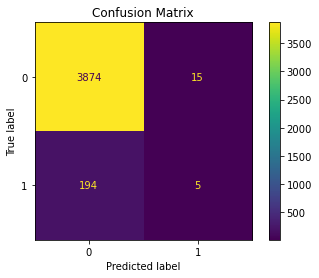

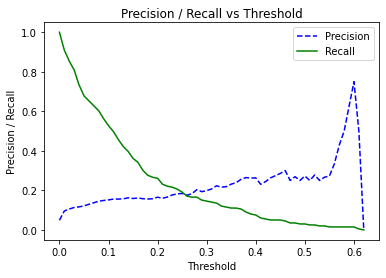

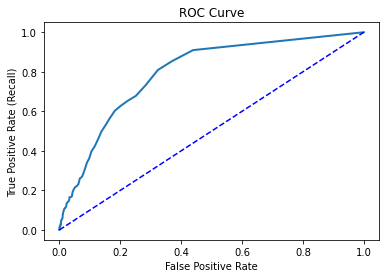

Precision Score: 0.25
Recall Score: 0.03
Specificity Score: 1.0
F1 Score: 0.05
F2 Score: 0.03
AUC Score: 0.51
Accuracy Score: 0.95
Balanced Accuracy: 0.51

 ======= Balanced Bag Classifier Sampler: SMOTE ======= 


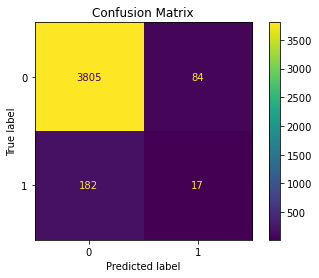

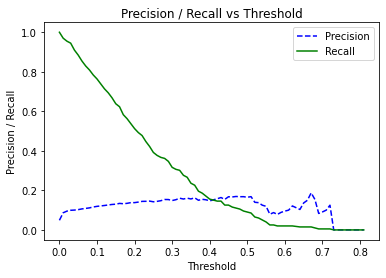

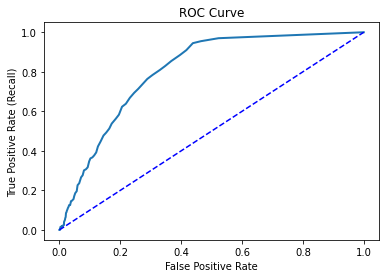

Precision Score: 0.17
Recall Score: 0.09
Specificity Score: 0.98
F1 Score: 0.11
F2 Score: 0.09
AUC Score: 0.53
Accuracy Score: 0.93
Balanced Accuracy: 0.53



In [103]:
# iterating through samplers
samplers = {"RandUnderSamp": RandomUnderSampler(), "RandOverSamp": RandomOverSampler(), "SMOTE": SMOTE()}

for s in samplers.keys():
    print(f" ======= Balanced Bag Classifier Sampler: {s} ======= ")
    bagging_model = train_fit_model(BalancedBaggingClassifier, 
                                     X_train=X_train_transformed, 
                                     y_train=y_train,
                                     random_state=RANDOM_STATE,
                                     n_estimators=100,
                                     sampler=samplers[s])
    model_results[str("bal_bag_clf_"+s)] = evaluate_model(bagging_model, 
                                                          X_train=X_train_transformed, 
                                                          y_train=y_train, 
                                                          ensemble=True)
    print()

In [104]:
print_results()

,Precision,Recall,Specificity,F1,F2,ROC,Accuracy,Balanced_Accuracy
logit_clf,0.50,0.01,1.00,0.01,0.01,0.50,0.95,0.50
logit_clf_smote,0.13,0.75,0.75,0.23,0.39,0.75,0.75,0.75
rf_clf,0.06,0.01,1.00,0.01,0.01,0.50,0.95,0.50
rf_clf_smote,0.15,0.39,0.89,0.22,0.30,0.64,0.86,0.64
psvm_clf,0.13,0.78,0.73,0.22,0.39,0.75,0.73,0.75
bal_rf_clf,0.12,0.82,0.70,0.21,0.38,0.76,0.70,0.76
bal_rf_OE_clf,0.13,0.82,0.72,0.22,0.40,0.77,0.72,0.77
bal_bag_clf,0.15,0.69,0.80,0.25,0.40,0.75,0.79,0.75
bal_bag_clf_RandUnderSamp,0.15,0.69,0.80,0.25,0.40,0.75,0.79,0.75
bal_bag_clf_RandOverSamp,0.25,0.03,1.00,0.05,0.03,0.51,0.95,0.51


By default, `BalancedBaggingClassifier` uses `RandomUnderSampling` method. It seems that both oversampling methods (Random  and SMOTE) seem to hurt the model performance even more.

### Model Selection

In [105]:
print_results()

,Precision,Recall,Specificity,F1,F2,ROC,Accuracy,Balanced_Accuracy
logit_clf,0.50,0.01,1.00,0.01,0.01,0.50,0.95,0.50
logit_clf_smote,0.13,0.75,0.75,0.23,0.39,0.75,0.75,0.75
rf_clf,0.06,0.01,1.00,0.01,0.01,0.50,0.95,0.50
rf_clf_smote,0.15,0.39,0.89,0.22,0.30,0.64,0.86,0.64
psvm_clf,0.13,0.78,0.73,0.22,0.39,0.75,0.73,0.75
bal_rf_clf,0.12,0.82,0.70,0.21,0.38,0.76,0.70,0.76
bal_rf_OE_clf,0.13,0.82,0.72,0.22,0.40,0.77,0.72,0.77
bal_bag_clf,0.15,0.69,0.80,0.25,0.40,0.75,0.79,0.75
bal_bag_clf_RandUnderSamp,0.15,0.69,0.80,0.25,0.40,0.75,0.79,0.75
bal_bag_clf_RandOverSamp,0.25,0.03,1.00,0.05,0.03,0.51,0.95,0.51


Looking at the results of the three models that we have tested, we will use the `BalancedRandomForestClassifier` (`bal_rf_clf`) the base case of our evaluation, as it a high Recall score as well as fairly good ROC AUC Score.

> ```python
bal_rf_clf = train_fit_model(BalancedRandomForestClassifier, 
                             X_train=X_train_transformed, 
                             y_train=y_train,
                             random_state=RANDOM_STATE,
                             n_estimators=100)
>```


##### Checkpoint: save model 

In [328]:
# save baseline model
joblib.dump(bal_rf_clf, Path("./models/bal_rf_clf.pkl"))

['models/bal_rf_clf.pkl']

### Hyperparameter Tuning

Let's look at our baseline model `bal_rf_clf` and get its current parameters 

In [107]:
pp(bal_rf_clf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 158,
 'replacement': False,
 'sampling_strategy': 'auto',
 'verbose': 0,
 'warm_start': False}


#### Randomized Hyperparameter Grid

In [306]:
RandomSearchCV_params = {
    # sampling with replacement or with no replacement
    "bootstrap": [True, False],
    # number of trees in the forest
    "n_estimators": [x for x in range(200, 2200, 200)],
    # maximum level of a tree. If None. If None, then nodes are expanded until all
    ## leaves are pure or until all leaves contain less than min_samples_split samples.
    "max_depth": [x for x in range(10, 110, 10)],
    # number of features to consider when looking for the best splirt
    "max_features": ["auto", "sqrt", "log2", 0.5],
    # minimum number of samples before splitting
    "min_samples_split": [2, 4, 8, 10, 20],
    # min_samples_leaf
    "min_samples_leaf": [1, 2, 4, 0.5]
}

In [312]:
bal_rf_clf_random = RandomizedSearchCV(estimator=bal_rf_clf,
                                cv=3, 
                                n_iter=100,
                                random_state=RANDOM_STATE, 
                                param_distributions=RandomSearchCV_params,
                                verbose=2)

In [313]:
bal_rf_clf_random.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=90, max_features=0.5, min_samples_leaf=2, min_samples_split=4, n_estimators=2000; total time=   8.3s
[CV] END bootstrap=True, max_depth=90, max_features=0.5, min_samples_leaf=2, min_samples_split=4, n_estimators=2000; total time=   8.2s
[CV] END bootstrap=True, max_depth=90, max_features=0.5, min_samples_leaf=2, min_samples_split=4, n_estimators=2000; total time=   8.4s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;

RandomizedSearchCV(cv=3,
                   estimator=BalancedRandomForestClassifier(random_state=158),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         0.5],
                                        'min_samples_leaf': [1, 2, 4, 0.5],
                                        'min_samples_split': [2, 4, 8, 10, 20],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=158, scoring='f1', verbose=2)

In [113]:
# this model was previously saved as Path("./models/bal_rf_best_random.pkl"). We will load it using joblib

bal_rf_best_random_clf = joblib.load(Path("./models/bal_rf_best_random.pkl"))

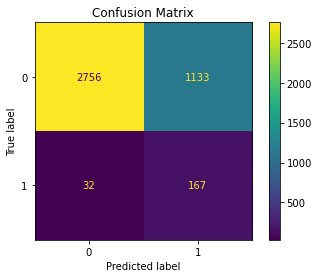

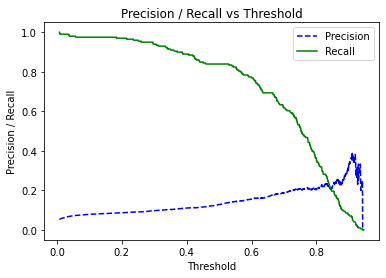

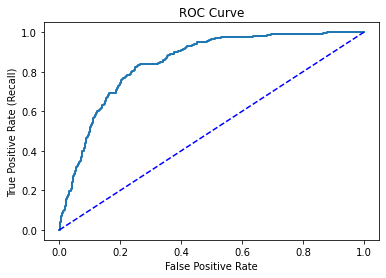

Precision Score: 0.13
Recall Score: 0.84
Specificity Score: 0.71
F1 Score: 0.22
F2 Score: 0.4
AUC Score: 0.77
Accuracy Score: 0.72
Balanced Accuracy: 0.77


In [114]:
# commented out as model was loaded from disk
# bal_rf_best_random_cl = bal_rf_clf_random.best_estimator_

model_results["bal_rf_best_random_clf"] = evaluate_model(bal_rf_best_random_clf,
                                                         X_train=X_train_transformed, 
                                                         y_train=y_train, 
                                                         ensemble=True)

In [115]:
print_results()

,Precision,Recall,Specificity,F1,F2,ROC,Accuracy,Balanced_Accuracy
logit_clf,0.50,0.01,1.00,0.01,0.01,0.50,0.95,0.50
logit_clf_smote,0.13,0.75,0.75,0.23,0.39,0.75,0.75,0.75
rf_clf,0.06,0.01,1.00,0.01,0.01,0.50,0.95,0.50
rf_clf_smote,0.15,0.39,0.89,0.22,0.30,0.64,0.86,0.64
psvm_clf,0.13,0.78,0.73,0.22,0.39,0.75,0.73,0.75
bal_rf_clf,0.12,0.82,0.70,0.21,0.38,0.76,0.70,0.76
bal_rf_OE_clf,0.13,0.82,0.72,0.22,0.40,0.77,0.72,0.77
bal_bag_clf,0.15,0.69,0.80,0.25,0.40,0.75,0.79,0.75
bal_bag_clf_RandUnderSamp,0.15,0.69,0.80,0.25,0.40,0.75,0.79,0.75
bal_bag_clf_RandOverSamp,0.25,0.03,1.00,0.05,0.03,0.51,0.95,0.51


> We (`bal_rf_best_randomclf`) seem to have better improvement in our model performance (higher recall and ROC) over our baseline model `bal_rf_clf`!

Let's check the parameters that were used in this model

In [116]:
bal_rf_best_random_clf.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 80,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 158,
 'replacement': False,
 'sampling_strategy': 'auto',
 'verbose': 0,
 'warm_start': False}

This helps us to narrow down our parameter search space using `GridSearchCV`

##### Checkpoint: save model 

In [329]:
# save baseline model
joblib.dump(bal_rf_best_random_clf, Path("./models/bal_rf_best_random.pkl"))

['models/bal_rf_best_random.pkl']

#### GridSearchCV

In [343]:
GridSearchCV_params = {
    # sampling with replacement or with no replacement
    "bootstrap": [False],
    # number of trees in the forest
    "n_estimators": [100, 2000, 2500, 3000],
    # maximum level of a tree. If None. If None, then nodes are expanded until all
    ## leaves are pure or until all leaves contain less than min_samples_split samples.
    "max_depth": [60, 80, 100, 120],
    # number of features to consider when looking for the best splirt
    "max_features": [0.5],
    # minimum number of samples before splitting
    "min_samples_split": [2, 4, 6, 8],
    # min_samples_leaf
    "min_samples_leaf": [2, 4, 6, 8]
}

In [344]:
bal_rf_clf_gridsearch = GridSearchCV(estimator=bal_rf_clf,
                                cv=3,
                                param_grid=GridSearchCV_params,
                                verbose=2)

In [345]:
bal_rf_clf_gridsearch.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits
[CV] END bootstrap=False, max_depth=60, max_features=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   7.4s
[CV] END bootstrap=False, max_depth=60, max_features=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   7.9s
[CV] END bootstrap=False, max_depth=60, max_features=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   7.8s
[CV] END bootstrap=False, max_depth=60, max_features=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=2500; 

GridSearchCV(cv=3, estimator=BalancedRandomForestClassifier(random_state=158),
             param_grid={'bootstrap': [False], 'max_depth': [60, 80, 100, 120],
                         'max_features': [0.5],
                         'min_samples_leaf': [2, 4, 6, 8],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [100, 2000, 2500, 3000]},
             scoring='f1', verbose=2)

In [117]:
bal_rf_best_gs_clf = joblib.load(Path("./models/bal_rf_best_gs_clf.pkl"))

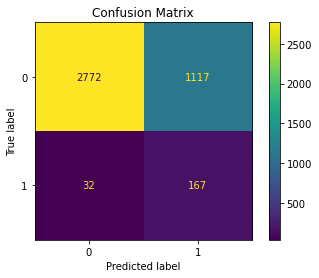

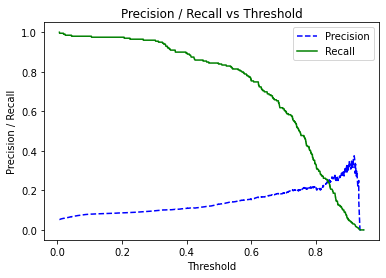

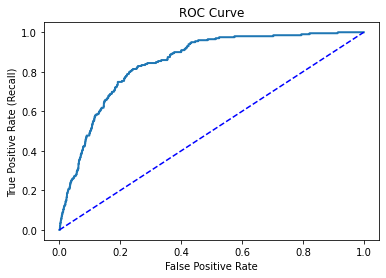

Precision Score: 0.13
Recall Score: 0.84
Specificity Score: 0.71
F1 Score: 0.23
F2 Score: 0.4
AUC Score: 0.78
Accuracy Score: 0.72
Balanced Accuracy: 0.78


In [118]:
# commented out as model was loaded from disk
#bal_rf_best_gs_clf = bal_rf_clf_gridsearch.best_estimator_

model_results["bal_rf_best_gs_clf"] = evaluate_model(bal_rf_best_gs_clf,
                                                         X_train=X_train_transformed, 
                                                         y_train=y_train, 
                                                         ensemble=True)

In [119]:
print_results()

,Precision,Recall,Specificity,F1,F2,ROC,Accuracy,Balanced_Accuracy
logit_clf,0.50,0.01,1.00,0.01,0.01,0.50,0.95,0.50
logit_clf_smote,0.13,0.75,0.75,0.23,0.39,0.75,0.75,0.75
rf_clf,0.06,0.01,1.00,0.01,0.01,0.50,0.95,0.50
rf_clf_smote,0.15,0.39,0.89,0.22,0.30,0.64,0.86,0.64
psvm_clf,0.13,0.78,0.73,0.22,0.39,0.75,0.73,0.75
bal_rf_clf,0.12,0.82,0.70,0.21,0.38,0.76,0.70,0.76
bal_rf_OE_clf,0.13,0.82,0.72,0.22,0.40,0.77,0.72,0.77
bal_bag_clf,0.15,0.69,0.80,0.25,0.40,0.75,0.79,0.75
bal_bag_clf_RandUnderSamp,0.15,0.69,0.80,0.25,0.40,0.75,0.79,0.75
bal_bag_clf_RandOverSamp,0.25,0.03,1.00,0.05,0.03,0.51,0.95,0.51


> Using grid search `bal_rf_best_gf_clf` does not seem to provide much improvement (Recall and ROC) over our previous iteration `bal_rf_best_random_clf`

Let's check the parameters that were used in this model

In [120]:
bal_rf_best_gs_clf.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 60,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 158,
 'replacement': False,
 'sampling_strategy': 'auto',
 'verbose': 0,
 'warm_start': False}

##### Checkpoint: save model 

In [349]:
# save baseline model
joblib.dump(bal_rf_best_gs_clf, Path("./models/bal_rf_best_gs_clf.pkl"))

['models/bal_rf_best_gs_clf.pkl']

### Moving Threshold

As the models provide probabilities of the predictions, we can actually _tune_ the threshold in order optimize our performance based on the metrics that we have chosen.  the threshold ptimal threshold when converting probabilities to crisp class labels for imbalanced classification.

============ Threshold: 0.1 ============


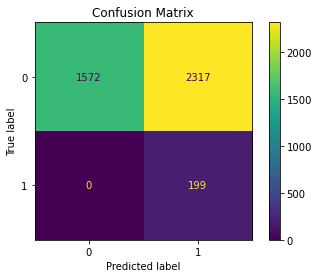

Precision Score: 0.08
Recall Score: 1.0
Specificity Score: 0.4
F1 Score: 0.15
F2 Score: 0.3
AUC Score: 0.7
Accuracy Score: 0.43
Balanced Accuracy: 0.7

============ Threshold: 0.2 ============


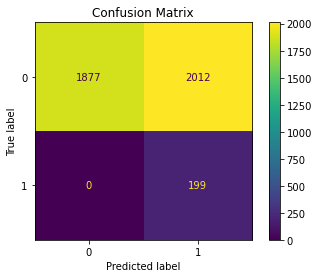

Precision Score: 0.09
Recall Score: 1.0
Specificity Score: 0.48
F1 Score: 0.17
F2 Score: 0.33
AUC Score: 0.74
Accuracy Score: 0.51
Balanced Accuracy: 0.74

============ Threshold: 0.3 ============


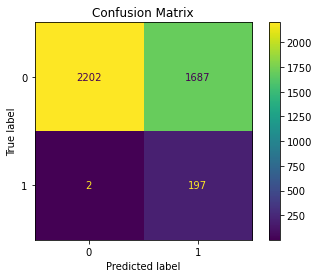

Precision Score: 0.1
Recall Score: 0.99
Specificity Score: 0.57
F1 Score: 0.19
F2 Score: 0.37
AUC Score: 0.78
Accuracy Score: 0.59
Balanced Accuracy: 0.78

============ Threshold: 0.4 ============


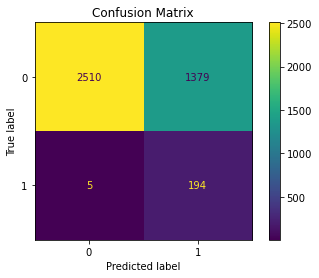

Precision Score: 0.12
Recall Score: 0.97
Specificity Score: 0.65
F1 Score: 0.22
F2 Score: 0.41
AUC Score: 0.81
Accuracy Score: 0.66
Balanced Accuracy: 0.81

============ Threshold: 0.5 ============


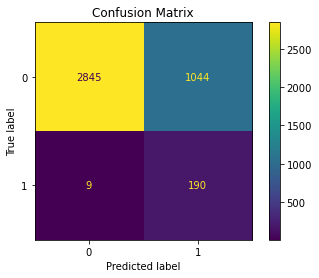

Precision Score: 0.15
Recall Score: 0.95
Specificity Score: 0.73
F1 Score: 0.27
F2 Score: 0.47
AUC Score: 0.84
Accuracy Score: 0.74
Balanced Accuracy: 0.84

============ Threshold: 0.6 ============


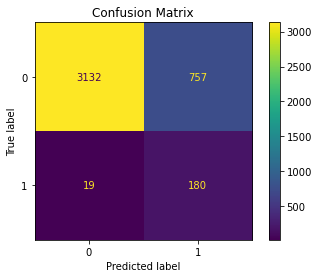

Precision Score: 0.19
Recall Score: 0.9
Specificity Score: 0.81
F1 Score: 0.32
F2 Score: 0.52
AUC Score: 0.85
Accuracy Score: 0.81
Balanced Accuracy: 0.85

============ Threshold: 0.7 ============


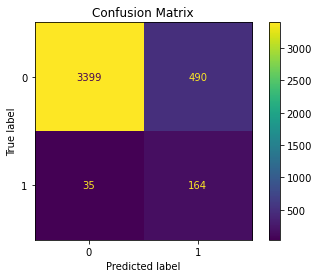

Precision Score: 0.25
Recall Score: 0.82
Specificity Score: 0.87
F1 Score: 0.38
F2 Score: 0.57
AUC Score: 0.85
Accuracy Score: 0.87
Balanced Accuracy: 0.85

============ Threshold: 0.8 ============


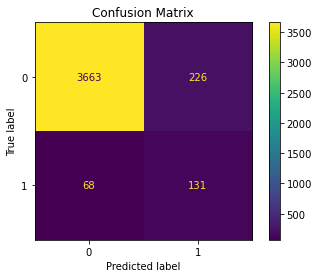

Precision Score: 0.37
Recall Score: 0.66
Specificity Score: 0.94
F1 Score: 0.47
F2 Score: 0.57
AUC Score: 0.8
Accuracy Score: 0.93
Balanced Accuracy: 0.8

============ Threshold: 0.9 ============


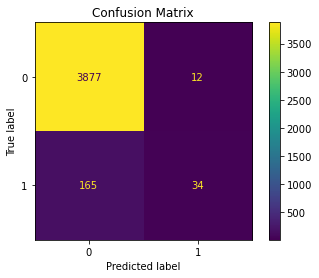

Precision Score: 0.74
Recall Score: 0.17
Specificity Score: 1.0
F1 Score: 0.28
F2 Score: 0.2
AUC Score: 0.58
Accuracy Score: 0.96
Balanced Accuracy: 0.58



,Precision,Recall,Specificity,F1,F2,ROC,Accuracy,Balanced_Accuracy
bal_rf_best_gs_clf,0.13,0.84,0.71,0.23,0.40,0.78,0.72,0.78
bal_rf_gs_thresh_0.1,0.08,1.00,0.40,0.15,0.30,0.70,0.43,0.70
bal_rf_gs_thresh_0.2,0.09,1.00,0.48,0.17,0.33,0.74,0.51,0.74
bal_rf_gs_thresh_0.3,0.10,0.99,0.57,0.19,0.37,0.78,0.59,0.78
bal_rf_gs_thresh_0.4,0.12,0.97,0.65,0.22,0.41,0.81,0.66,0.81
bal_rf_gs_thresh_0.5,0.15,0.95,0.73,0.27,0.47,0.84,0.74,0.84
bal_rf_gs_thresh_0.6,0.19,0.90,0.81,0.32,0.52,0.85,0.81,0.85
bal_rf_gs_thresh_0.7,0.25,0.82,0.87,0.38,0.57,0.85,0.87,0.85
bal_rf_gs_thresh_0.8,0.37,0.66,0.94,0.47,0.57,0.80,0.93,0.80
bal_rf_gs_thresh_0.9,0.74,0.17,1.00,0.28,0.20,0.58,0.96,0.58


In [121]:
threshold_results = {}
threshold_results["bal_rf_best_gs_clf"] = model_results["bal_rf_best_gs_clf"]

for threshold in np.linspace(0.1, 0.9, 9):
    print(f"============ Threshold: {threshold:.1f} ============")
    threshold_results[f"bal_rf_gs_thresh_{threshold:.1f}"] = evaluate_model(bal_rf_best_gs_clf,
                                                                            X_train=X_train_transformed, 
                                                                            y_train=y_train, 
                                                                            ensemble=True,
                                                                            threshold=threshold)
    print()
    
print_results(threshold_results)

We will choose `final_threshold` as 0.4, considering that it provides ~97% recall (which means out of 100 stroke patients that come in, we are able to detect at least 97 of them. It also has a reasonable ROC Score of 0.81.

In [122]:
final_threshold = 0.4

### Moment of Truth

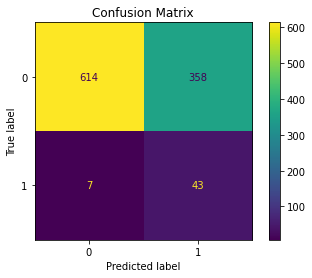

Precision Score: 0.11
Recall Score: 0.86
Specificity Score: 0.63
F1 Score: 0.19
F2 Score: 0.36
AUC Score: 0.75
Accuracy Score: 0.64
Balanced Accuracy: 0.75


{'Precision': 0.11,
 'Recall': 0.86,
 'Specificity': 0.63,
 'F1': 0.19,
 'F2': 0.36,
 'ROC': 0.75,
 'Accuracy': 0.64,
 'Balanced_Accuracy': 0.75}

In [123]:
evaluate_model(bal_rf_best_gs_clf, X_test_transformed,  y_test,  ensemble=True, threshold=final_threshold)

> The *Balanced Random Forest* model with a threshold of 0.4 was able to detect stroke patients with 86% recall score in the test set. However, it is difficult to gage what is considered to be a good performance benchmark as the dataset source (https://www.kaggle.com/fedesoriano/stroke-prediction-dataset/) did not divulge the original source or experiment of this dataset.

### Supplementary Evaluation

As we are using a Random Forest model, we will be able to determine which of the independent variables / features are playing the biggest predictive role in the model

In [124]:
def feature_importance(model, labels):
    
    feat_imp = pd.Series(model.feature_importances_, labels).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importance', color='g', figsize=(20,10)) 
    plt.ylabel('Feature Importance Score')

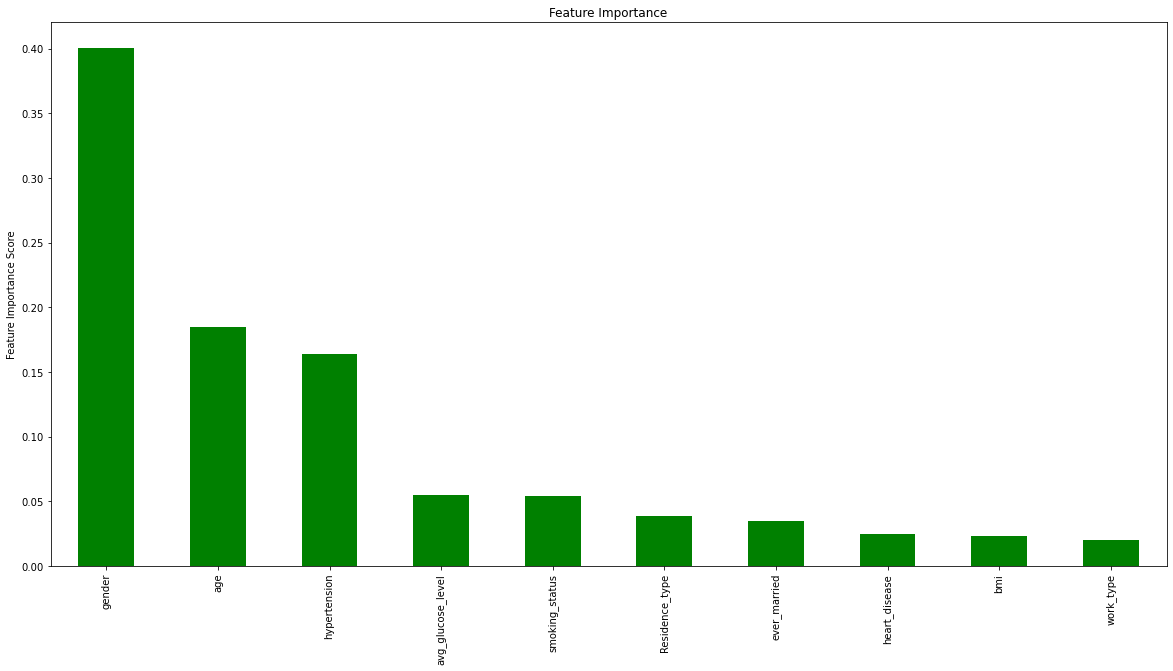

In [125]:
fi_labels = train_set.drop(columns=["stroke", "id"]).columns
feature_importance(bal_rf_OE_clf, fi_labels)

> From our evaluation, it seems that highest contributor to detecting Stroke patients is `gender`. The feature importance then is followed by `age`, `hypertension`, `avg_glucose_level` and `smoking_status`. 

References: 
1. https://elitedatascience.com/imbalanced-classes
2. https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
3. https://en.wikipedia.org/wiki/F-score
4. https://www.publichealth.columbia.edu/research/population-health-methods/evaluating-risk-prediction-roc-curves
5. https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
6. https://en.wikipedia.org/wiki/Precision_and_recall
7. Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow by Aurélien Géron